## Preparing the dataset

In [104]:
import numpy as np

import pandas as pd 
data_file_path = "spam.csv"
df = pd.read_csv(data_file_path, encoding="latin-1")
df = df.iloc[:,:2]
df.columns = ["Label", "Text"]
df


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [105]:
# Number of each class <ham> or <spam>
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [106]:
# Under-sampling to balance dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"]=="spam"].shape[0]
    ham_subset = df[df["Label"]=="ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df 
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [107]:
# Convert classes to 0 and 1
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

In [108]:
# Train/val/test split to 0.7/0.1/0.2
def random_split(df, train_frac, validation_frac):
    # shuffle DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df 

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Creating data loaders

In [109]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [110]:
# Setting up Dataset
import torch
from torch.utils.data import Dataset 

class SpamDataset(Dataset):
    # csv_file: 2 columns of "Label" (0 or 1) and "Text" (string)
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        # [[3,643,2], [7,1],...]
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else: # truncate sentence if too long
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        # pad sequence with <50256> to the length of longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id]*(self.max_length-len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index] # will have same length <max_length>
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long), # (max_length,)
            torch.tensor(label, dtype=torch.long) # (1,)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
print("Dataset max length: ", train_dataset.max_length)

Dataset max length:  103


In [111]:
# pad & truncate val/test dataset to <max-length> OF TRAIN
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [112]:
# Create DataLoaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

# each batch: X: <batch,max-length>=<8,103>; y: <batch,>=<8,>
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [113]:
# Print batch shape
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 103])
Label batch dimensions: torch.Size([8])


In [114]:
# How many batches in each dataset
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Initialize model with pre-trained weights (prepare for fine-tuning)

In [115]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers":48, "n_heads":25}
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [116]:
import torch.nn as nn
from gpt_download import download_and_load_gpt2

In [117]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # optional trainable params
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
  
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # (batch,1)
        # biased variance: divided by 1/(n-1)
        # unbiased variance: divided by 1/n
        var = x.var(dim=-1, keepdim=True, unbiased=False) # (batch,1)
        norm_x = (x-mean) / torch.sqrt(var+self.eps) # (batch,emb_dim)
        return self.scale * norm_x + self.shift # (batch,emb_dim)
        
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh( torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3)) ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
          GeLU(),
          nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
  
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out # 4
        self.num_heads = num_heads # 2
        self.head_dim = d_out // num_heads # 2

        # bigger weight matrices
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # compute big kqv matrices
        keys = self.W_key(x) # (b,n,3)=>(b,n_token,4)
        queries = self.W_query(x) # (b,n,3)=>(b,n_token,4)
        values = self.W_value(x) # (b,n,3)=>(b,n_token,4)
        # ... then splits
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head=2,head_dim=2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        # swap <num_heads> to after-batch location
        keys = keys.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        queries = queries.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        values = values.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)

        attn_scores = queries @ keys.transpose(2,3) # (b,n_head,n_token,head_dim)@(b,n_head,head_dim,n_token)=>(b,n_head,n_token,n_token)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf) # (n,n) with upper-right is -inf
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # (b,n_head,n_token,n_token)

        context_vec = (attn_weights @ values).transpose(1,2) # (b,n_head,n_token,head_dim=2)=>transpose to (b,n_token,n_head,head_dim=2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out) # (b,n_token,n_head*head_dim)=(b,n_token,4)
        context_vec = self.out_proj(context_vec) # (b,n_token,4)

        return context_vec # (b,n_token,4)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x 

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # in_idx: (batch,seq_len), each element is a token-index (integer shows location)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # (batch,seq_len)=>(batch,seq_len,emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (1,seq_len)=>(1,seq_len,emb_dim)
        x = tok_embeds + pos_embeds # (batch,seq_len,emb_dim)
        x = self.drop_emb(x) # (batch,seq_len,emb_dim)
        x = self.trf_blocks(x) # (batch,seq_len,emb_dim)
        x = self.final_norm(x) # (batch,seq_len,emb_dim)
        logits = self.out_head(x) # (batch,seq_len,vocab_len)
        return logits

# small utils function: check if <left> and <right> has matching shape
# if yes then return <Parameter> as the right tensor
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    # load positional encoding
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    # load token embedding
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    # load transformers blocks
    for b in range(len(params["blocks"])):
        # params["blocks"][b]["attn"]: <multi-head-attn> part
        # <multi-head-attn>["c_attn"]: convolution attention (of qkv) inside
        # split to 3 parts <query>,<key>,<value>
        q_w, k_w, v_w = np.split( params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1) # each (768,768)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # bias of <attn> in <multi-head-attention>
        q_b, k_b, v_b = np.split( params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1) # each (768,)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        # out-projection of <attn> in <multi-head-attention>
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        # feed-forward; layer0 & layer1 (layer1 is GeLU)
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        # layer normalization
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    # Final layer normalization
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    # Out weight
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) # we use the token embedding weights again ("weight tying")

In [118]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")") # 124M
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [119]:
# Check model loading is successful, by generating some meaningful text
import tiktoken

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx: (batch, n_tokens_long)
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] # take last <context_size> tokens as context => (batch,context_size)
        with torch.no_grad():
            logits = model(idx_cond) # (batch,context_size,vocab_len)
        logits = logits[:,-1,:] # last tokenS - (batch,vocab_len)
        probas = torch.softmax(logits,dim=-1) # (batch,vocab_len)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (batch,1)
        idx = torch.cat((idx, idx_next), dim=1) #(batch,n_tokens_long+1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # (n_tokens,)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # (1,n_tokens)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # (n_tokens,)
    return tokenizer.decode(flat.tolist())

In [120]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
# token_ids: (1,n_tokens_long+max_new_tokens)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [121]:
# Try to classify spams with prompting => not good
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a classification head

In [122]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [123]:
# First freeze every layers
for param in model.parameters():
    param.requires_grad = False
# Replace last layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)
# Make the last <transformer> block AND final <LayerNorm> trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True 

In [124]:
# Try feeding an example text
inputs = tokenizer.encode("Do you have time") # list of 4 ints
inputs = torch.tensor(inputs).unsqueeze(0) # (batch,n_token)=(1,4)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [125]:
# Prediction output => take last token
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs) # (batch,n_token,out_dim)=(1,4,2)
print("Outputs dimensions:", outputs.shape)
print("Last output token:", outputs[:,-1,:])

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-3.5983,  3.9902]])


## Calculating the classification loss and accuracy

In [126]:
# Current class prediction: not correct
print("Last output token:", outputs[:,-1,:]) # (1,2)
probas = torch.softmax(outputs[:,-1,:], dim=-1) # (1,2)
label = torch.argmax(probas)
print("Class label:", label.item())

Last output token: tensor([[-3.5983,  3.9902]])
Class label: 1


In [127]:
# Calculating classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    # <input_batch>: (batch,n_words)=(8,103)
    # <target_batch>: (batch,)=(8,)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:,-1,:] # last of (batch,n_words,n_class)=>(batch,2)
            predicted_labels = torch.argmax(logits, dim=-1) # (batch,)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels==target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [128]:
# evaluate accuracy over 10 batches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [129]:
# for classification: we use <cross-entropy> loss of the last token row
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) # (batch,n_words)
    target_batch = target_batch.to(device) # (batch,)
    logits = model(input_batch)[:,-1,:] # (batch,n_word,n_class)=>(batch,n_class)
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


In [130]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [131]:
# Calculate loss for train/val/test dataset
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, model, device, num_batches=5
    )
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 2.322
Validation loss: 2.558
Test loss: 2.316


## Fine-tuning model on supervised data

In [132]:
# eval_iter: num_batches to evaluate accuracy (of train/val)
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [133]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    # eval_iter: num_batches to evaluate accuracy (of train/val)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    # examples_seen: add up #samples-per-batch when each batch passing
    # global_step: add up 1 after each batch passing
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            examples_seen += input_batch.shape[0]
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen    


In [134]:
# Training
import time

start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 50
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.015, Val loss 2.988
Ep 1 (Step 000050): Train loss 0.645, Val loss 0.594
Ep 1 (Step 000100): Train loss 0.485, Val loss 0.495
Training accuracy: 82.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.413, Val loss 0.444
Ep 2 (Step 000200): Train loss 0.394, Val loss 0.407
Ep 2 (Step 000250): Train loss 0.297, Val loss 0.283
Training accuracy: 87.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.417, Val loss 0.486
Ep 3 (Step 000350): Train loss 0.253, Val loss 0.463
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.351, Val loss 0.367
Ep 4 (Step 000450): Train loss 0.468, Val loss 0.355
Ep 4 (Step 000500): Train loss 0.246, Val loss 0.283
Training accuracy: 90.00% | Validation accuracy: 92.50%
Ep 5 (Step 000550): Train loss 0.198, Val loss 0.308
Ep 5 (Step 000600): Train loss 0.203, Val loss 0.135
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 6 (Step 000650): Train loss 

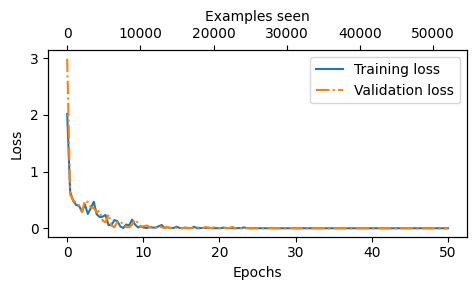

In [135]:
# Plot losses
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Invisible plot for aligning ticks
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plt.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses)) # examples_seen: 5200, len(train_losses): 13
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

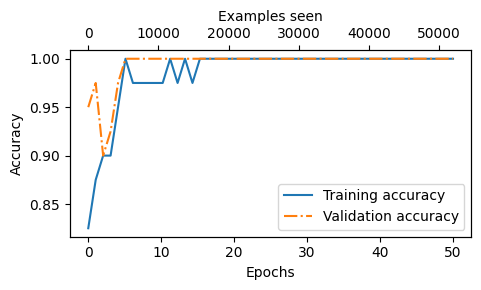

In [136]:
# plot accuracy 
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [137]:
# Print dataset accuracies
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 100.00%
Validation accuracy: 98.66%
Test accuracy: 97.00%


## Using LLM as a spam classifier

In [138]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text) # list of ints
    # pos_emb: (context_length,embed_dim)=(1024,768)
    supported_context_length = model.pos_emb.weight.shape[0] # 1024
    input_ids = input_ids[:min(max_length, supported_context_length)]
    # pad input to reach 103 tokens length
    input_ids += [pad_token_id] * (max_length-len(input_ids))
    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0) # (1,103)
    with torch.no_grad():
        logits = model(input_tensor)[:,-1,:] # (1,103,2)=>(1,2)
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

text_1 = "You are a winner you have been specially selected to receive $1000 cash or $2000 award."
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length)) 

spam


In [139]:
text_2 = "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam
